## Student: Tyler Lang

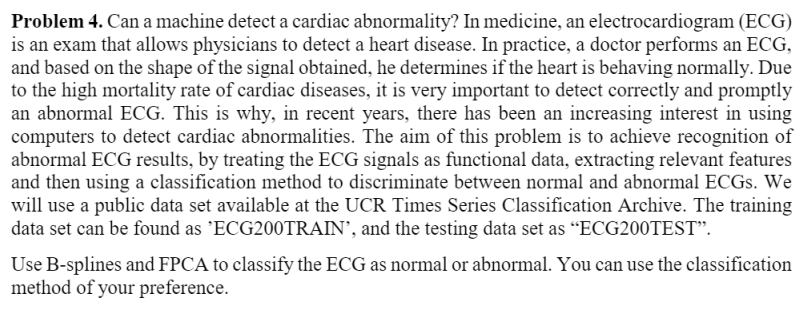

In [26]:
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 E261
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from scipy.interpolate import splrep, splev
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import interpolate
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score


def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    # This is directly taken from Practice Code
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

To solve this question, I have all needed packages loaded above, and will now solve first a naive model to use as a basis for comparison with modeling using input data transformed with B-splines and via FPCA. 

Below, I load the data given to us, and separate the dependent and independent variables. In this dataset, the dependent variable is coded as 1 vs -1, which detect if an input is classified as normal vs abnormal. The data points specifically are ECG results, which are already pre-classified. The idea is that hopefully dimensionality reduction via BSplines and FPCA might help with separability of the two classes and lead to higher classification accuracy by a machine learning model. 

Below, I load the data and separate the classification value with the measures:

In [27]:
train = pd.read_csv(r"../ECG200TRAIN",header=None)
test = pd.read_csv(r"../ECG200TEST",header=None)

In [28]:
train_x = np.array(train.loc[:,1:])
train_y = np.array(train.loc[:,0])

test_x = np.array(test.loc[:,1:])
test_y = np.array(test.loc[:,0])

# Naive Test - No Data Manipulations

Throughout this homework question, I will use a random forest classifier as a base classifier to compare results across the naive test, the BSpline test, and the FPCA test. While I would normally  tune each random forest's parameters to get the best accuracy, the goal of this homework is to see how **Bsplines and FPCA** as new input data alter accuracies from the same base model, and thus no tuning in terms of the classifier algorithm itself will be performed. This was confirmed as being an ok practice in Piazza posts.

Below, I create a basic model using raw data, and report the confusion matrix and accuracy score of prediction on the test set, with 0 tuning:

In [18]:
rf = RandomForestClassifier(random_state=1993)
rf.fit(train_x,train_y)
p_naive = rf.predict(test_x)
c_naive = pd.DataFrame(confusion_matrix(test_y,p_naive),index=['Class 0', 'Class 1'], columns=['Predicted 0','Predicted 1'])
print(c_naive)
print(f"\n Accuracy Score: {accuracy_score(test_y,p_naive)}")

         Predicted 0  Predicted 1
Class 0           24           12
Class 1            7           57

 Accuracy Score: 0.81


That's already a pretty good classifier! But, due to the severity of heart disease, this might not be good enough for doctors to use to diagnose a patient, as it could lead to either false positive or false negatives, both of which are costly in medicine and health.

Thus, I will try to improve this accuracy using the two methods mentioned in the homework: B-splines and FPCA.

# Using B-Splines

## Base B-Spline Method: No Tuning

Just to get a sense of how B-splines in general might help prediction accuracy, I will transform the input data via B-splines, picking a random amount of knots to start (which I will then tune in the next section). To start, I pick 10 knots. 

In the next cell of code, a variable "x" is created to represent an interval of even spacing from 0 to 1, with a total number of intervals equal to the number of observations for our data points in our measured set. Then, I will create a separate interval of knots, also measured from 0 to 1, to keep the intervals consistent. 

In [19]:
x = np.linspace(0,1,train_x.shape[1])
knots = np.linspace(0,1,10)

Finally, as B-spline transformations are not dependent on the data present in our actual dataset (in the sense that the B-spline basis is created independently of our actual data measures), we can simply combine the train and test sets of our independent variables (the measures) in one to make the final transformation process simpler. 

In [20]:
X = np.concatenate([train_x,test_x],axis=0)
X.shape

(200, 96)

Finally, the Basis of a B-spline is created. A cubic B-spline is used, as it is the standard power for B-spline transformations.

Then, the coefficients are calculated using this basis and the "least squares" function from numpy, which is due to being more stable than taking inverses, which is the standard equation form. Least squares considers the inputs as the variables "a" and "b" in the equation "aX = b". Thus, below, we are solving for B_ceof in "B$\cdot$B_coef = X.T", where X is our concatenated array of train and test independent measures/observations, and B is our B-spline Basis. 

In [21]:
B = BSplineBasis(x,knots,3)[:,:-2]
Bcoef = np.linalg.lstsq(B,X.T,rcond=None)[0].T

In [22]:
Bcoef.shape

(200, 12)

Now that the final transformation is done, in which Bcoef is a reduced-dimension version of our original data (12 coefficients: 2 extremes and 10 knots), we can use any classification model from sklearn to see accuracy. First, we fit the model on the transformed training set, and test on the transformed test set, and finally compare the predictions with the real test_y values to get a final accuracy: 

In [23]:
rf = RandomForestClassifier(random_state=1993)
rf.fit(Bcoef[:len(train_x),:],train_y)
preds_Bspline = rf.predict(Bcoef[len(train_x):,:])
conf = confusion_matrix(test_y, preds_Bspline)
conf = pd.DataFrame(conf, index=['Class 0', 'Class 1'], columns=[
                    'Predicted 0', 'Predicted 1'])
print('Confusion Matrix - Splines\n', conf)
print(f"\n Accuracy Score: {accuracy_score(test_y,preds_Bspline)}")

Confusion Matrix - Splines
          Predicted 0  Predicted 1
Class 0           26           10
Class 1            6           58

 Accuracy Score: 0.84


As can be seen, just a basic B-spline transformation increases training accuracy by 3%! 

## B-Spline - Tuned 

While the accuracy went up a bit, I will try to make accuracy even better by tuning the number of knots. To do so, I split the training set up into test and validation sets, and use validation accuracy to determine the optimal knot number:

In [32]:
x_tr, x_val, y_tr, y_val = train_test_split(train_x,train_y,random_state=3)
kns = range(3,20)
acs = []
X_trval = np.vstack([x_tr,x_val])
for kn in kns:
    x = np.linspace(0,1,train_x.shape[1])
    knots = np.linspace(0,1,kn)
    B = BSplineBasis(x,knots,3)[:,:-2]
    #print(B.shape)
    Bcoef = np.linalg.lstsq(B,X_trval.T,rcond=None)[0].T
    rf = RandomForestClassifier(random_state=1993)
    rf.fit(Bcoef[:len(x_tr),:],y_tr)
    preds_Bspline = rf.predict(Bcoef[len(x_tr):,:])
    ac = accuracy_score(y_val, preds_Bspline)
    acs.append(ac)

In [38]:
print(B.shape, Bcoef.shape)
print(x_tr.shape,x_val.shape,train_x.shape)

(96, 21) (100, 21)
(75, 96) (25, 96) (100, 96)


In [11]:
print(f"Best performance for Knots = {np.argwhere(np.array(acs) ==np.max(acs))[0][0]} with validation accuracy of {np.max(acs)}")

Best performance for Knots = 8 with validation accuracy of 0.92


Wow! Validation accuracy is as high as 92%. This will probably go down in true accuracy, but it is found that 8 knots is ideal. Now, re-training the model with the full training set, and finally getting the test error: 

In [12]:
best_knots = np.argwhere(np.array(acs) ==np.max(acs))[0][0]
knots = np.linspace(0,1,best_knots)
B = BSplineBasis(x,knots,3)[:,:-2]
Bcoef = np.linalg.lstsq(B,X.T,rcond=None)[0].T
rf = RandomForestClassifier(random_state=1993)
rf.fit(Bcoef[:len(train_x),:],train_y)
preds_Bspline = rf.predict(Bcoef[len(train_x):,:])
conf = confusion_matrix(test_y, preds_Bspline)
conf = pd.DataFrame(conf, index=['Class 0', 'Class 1'], columns=[
                    'Predicted 0', 'Predicted 1'])
print('Confusion Matrix - Splines\n', conf)
print(f"\n Accuracy Score: {accuracy_score(test_y,preds_Bspline)}")

Confusion Matrix - Splines
          Predicted 0  Predicted 1
Class 0           31            5
Class 1            6           58

 Accuracy Score: 0.89


As can be seen, a tuned B-spline manipulation increased accuracy to 89%! A full 8% higher than the original vanilla model! 

# Functional Principal Components

## Un-tuned FPCA Model

Now, I will try using functional principal components. To do so, I will be using code from the sample code provided to us in lecture. First, for F-PCA, we have to perform it on all available data for the independent measures. Thus, we have to concatenate the train and test sets into one variable: Y. Then, the mean is grabbed from the positive and negative classes of all defined data (this new Y). 

This first round of prediction is a simple, un-tuned model. After seeing results, I will try to possibly tune or improve results even more.

In [13]:
Y = np.concatenate([train_y,test_y])
positive_class = X[pd.Series(Y)==1]
negative_class = X[pd.Series(Y)==-1]
mean1 = np.mean(positive_class,axis=0)
mean2 = np.mean(negative_class,axis=0)

Next, I have to create the covariance matrix, which we will finally use in eigendecomposition. To do so, for FPCA we need a $\hat\mu$ value to compare our measures from, and thus, the best way to get this $\hat\mu$ is by using our B-spline, and comparing to our original measures. Finally, we take the difference of all x values and this list of means, and take the covariance matrix of these differences. 

In [49]:
B_stacked = np.tile(B.T, 200).T
X_stacked = X.ravel()
beta = np.linalg.lstsq(B_stacked, X_stacked,rcond=None)[0]
mu_hat = B.dot(beta)  
diffs = X-mu_hat
Cov = np.cov(diffs.T)

Now, I simply take eigen-decomposition of the covariance matrix, as is standard for any PCA procedure, and pick a desired amount of principal components, and taking the first n-components, given that the components are ordered by how much model variance they explain, and we want to maximize explanatory power of our chosen components. 

Just for the purposes of simplicity, I will just take the first 2 components, which may or may not lead to poor accuracy. Then, I will tune this value later in the next section.

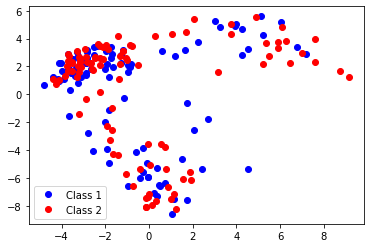

In [15]:
M = X.shape[0]//2
pc_qty = 2
l, psi = np.linalg.eigh(Cov)
PCs = psi[:, -pc_qty:]
FPC_scores = diffs.dot(PCs)
plt.plot(FPC_scores[:M,0],FPC_scores[:M,1],'bo',label='Class 1')
plt.plot(FPC_scores[M:,0],FPC_scores[M:,1],'ro',label='Class 2')
plt.legend()
plt.show()

In [16]:
rf = RandomForestClassifier(random_state=1993)
rf.fit(FPC_scores[:len(train_x), :], train_y)
pred_fpca = rf.predict(FPC_scores[len(train_x):, :])
conf = confusion_matrix(test_y, pred_fpca)
conf = pd.DataFrame(conf, index=['Class 0', 'Class 1'], columns=[
                    'Predicted 0', 'Predicted 1'])
print('Confusion Matrix - FPCA\n', conf)
print(f"Accuracy Score Using FPCA: {accuracy_score(test_y,pred_fpca)}")

Confusion Matrix - FPCA
          Predicted 0  Predicted 1
Class 0           21           15
Class 1            9           55
Accuracy Score Using FPCA: 0.76


As can be seen, this actually lowered accuracy by 5%. But this is an untuned model, and I only chose 2 components, which may not explain enough of the variability. Thus, I will now tune the amount of PCs desired:

## Tuned FPCA

The main tuning required is tuning the amount of PCs taken from the eigendecomposition.

In [17]:
accs_fpca_nonsmooth = []
for i in range(2,psi.shape[1]):
    PCs = psi[:, -i:]
    FPC_scores = diffs.dot(PCs)
    rf = RandomForestClassifier(random_state=1993)
    rf.fit(FPC_scores[:len(train_x), :], train_y)
    pred_fpca = rf.predict(FPC_scores[len(train_x):, :])
    accs_fpca_nonsmooth.append(accuracy_score(test_y,pred_fpca))

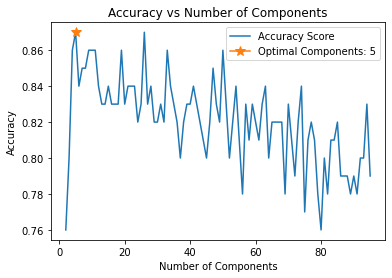

Final Accuracy: 0.87


In [18]:
num_PCs = range(2,psi.shape[1])[np.argmax(accs_fpca_nonsmooth)]
acc = accs_fpca_nonsmooth[np.argmax(accs_fpca_nonsmooth)]
label = f'Optimal Components: {num_PCs}'
sns.lineplot(x=range(2,psi.shape[1]), y=accs_fpca_nonsmooth,label='Accuracy Score')
plt.plot(num_PCs,acc, marker="*", markersize=10,label = label)
plt.title('Accuracy vs Number of Components')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()
print(f"Final Accuracy: {acc}")

As can be seen, the optimal FPCA model still did not perform as well as the B-spline, which got to an 89% accuracy! Although, FPCA still did better than the base model, by 6%! 

Finally, the last thing I can do to try to increase accuracy a bit more is using a gaussian filter on the covariance matrix to try to smooth out the covariance matrix a bit, making it less susceptible to inaccuracies due to outliers or noise! Thus, I will pass a gaussian filter on the covariance matrix, and complete the same process to see final max accuracy gained by FPCA: 

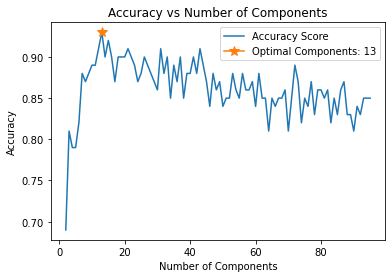

Final Accuracy: 0.93


In [19]:
Cov = np.cov(diffs.T)
Cov = gaussian_filter(Cov, sigma=7)
l, psi = np.linalg.eigh(Cov)

accs_fpca_nonsmooth = []
for i in range(2,psi.shape[1]):
    PCs = psi[:, -i:]
    FPC_scores = diffs.dot(PCs)
    rf = RandomForestClassifier(random_state=1993)
    rf.fit(FPC_scores[:len(train_x), :], train_y)
    pred_fpca = rf.predict(FPC_scores[len(train_x):, :])
    accs_fpca_nonsmooth.append(accuracy_score(test_y,pred_fpca))

    
num_PCs = range(2,psi.shape[1])[np.argmax(accs_fpca_nonsmooth)]
acc = accs_fpca_nonsmooth[np.argmax(accs_fpca_nonsmooth)]
label = f'Optimal Components: {num_PCs}'
sns.lineplot(x=range(2,psi.shape[1]), y=accs_fpca_nonsmooth,label='Accuracy Score')
plt.plot(num_PCs,acc, marker="*", markersize=10,label = label)
plt.title('Accuracy vs Number of Components')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()
print(f"Final Accuracy: {acc}")

Wow! Using a smoother covariance matrix, and 13 final components, accuracy jumped to 93%! Thus, FPCA parameter tuning was able to reach even higher accuracy than even the B-spline parameter tuning, making this potentially the best model thus far! That's really great accuracy. Thus, as we can see, a smoother covariance matrix DEFINITELY help improved prediction accuracy! How cool is that! 